# Lab in Python {#sec-spatial-w-Py .unnumbered}

There are several ways to create spatial weigths matrices so they contain an accurate representation that aligns with the way we understand spatial interactions between observations associated with different locations. In this session, we will introduce the most commonly used ones and will show how to compute them.

## Importing modules:

We start by importing the following modules:

In [4]:
import seaborn as sns
import pandas as pd
from pysal.lib import weights
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

## Data

For this session, we will use a dataset of small areas (or Lower layer Super Output Areas, LSOAs) for Liverpool, UK. The dataset is accessed remotely through the web or downloaded from GitHub and then loaded into the `df` variable:

In [5]:
# Read the file in
df = gpd.read_file("../data/Liverpool/liv_lsoas.gpkg")

## Building spatial weights

### Contiguity

Contiguity weights matrices define spatial connections through the existence of common boundaries. This makes it directly suitable to use with polygons: if two polygons share boundaries to some degree, they will be labeled as neighbors under these kinds of weights. We will learn two approaches, namely queen and rook, characterised by how much they need to share.

-   **Queen**

Under the queen criterion, two observations only need to share a vertex (a single point) of their boundaries to be considered neighbors. Constructing a weights matrix under these principles can be done by running:

In [6]:
w_queen = weights.Queen.from_dataframe(df, ids="LSOA11CD")
w_queen

The command above creates an object w_queen of the class `W`. This is the format in which spatial weights matrices are stored in `PySAL`. In reality, `w_queen` is not stored as a matrix containing values for each pair of observations, including zeros for those that are not neighbours. Instead, to save memory, for each observation it stores a list of those other observations that are neighbours according to the queen criterion, and it does not store any values for those observations that are not neighbours.

A `W` object can be queried to find out about the contiguity relations it contains. For example, if we would like to know who is a neighbor of observation E01006690:

In [7]:
w_queen['E01006690']

{'E01006697': 1.0,
 'E01006695': 1.0,
 'E01006691': 1.0,
 'E01006759': 1.0,
 'E01006692': 1.0,
 'E01033763': 1.0,
 'E01006720': 1.0}

This returns a Python dictionary that contains the ID codes of each neighbor as keys, and the weights they are assigned as values. Since we are looking at a raw queen contiguity matrix, every neighbor gets a weight of one. If we want to access the weight of a specific neighbor, E01006691 for example, we can do recursive querying:

In [8]:
w_queen['E01006690']['E01006691']

1.0

To check whether, for example, E01006519 is a neighbour of E01006690, we can run the following code:

In [9]:
'E01006519' in w_queen['E01006690'].keys()

False

Of course we obtain `False` since E01006519 does not appear in the list of neighbours of E01006690.

`W` objects also have a direct way to provide a list of all the neighbors or their weights for a given observation. This is thanks to the `neighbors` and `weights` attributes:

In [10]:
w_queen.neighbors['E01006690']

['E01006697',
 'E01006695',
 'E01006691',
 'E01006759',
 'E01006692',
 'E01033763',
 'E01006720']

In [11]:
w_queen.weights['E01006690']

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Once created, `W` objects can provide much information about the matrix, beyond the basic attributes one would expect. We have direct access to the number of neighbors each observation has via the attribute cardinalities. For example, to find out how many neighbors observation E01006524 has:

In [12]:
w_queen.cardinalities['E01006524']

6

Since `cardinalities` is a dictionary, it is direct to convert it into a `Series` object:

In [13]:
queen_card = pd.Series(w_queen.cardinalities)
queen_card.head()

E01006512    6
E01006513    9
E01006514    5
E01006515    8
E01006518    5
dtype: int64

This allows, for example, to access quick plotting, which comes in very handy to get an overview of the size of neighborhoods in general:

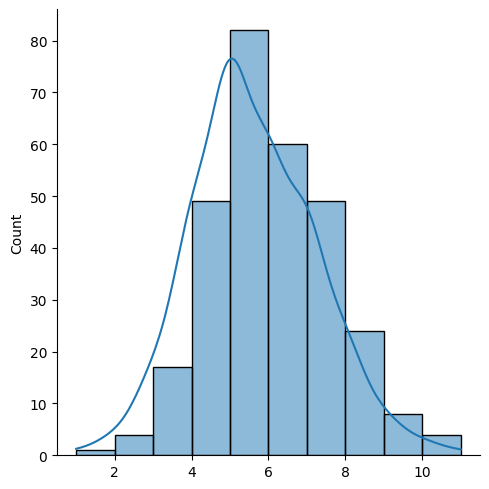

In [14]:
sns.displot(queen_card, bins=10,  kde=True)
plt.show()

The figure above shows how most observations have around five neighbors, but there is some variation around it. The distribution also seems to follow a symmetric form, where deviations from the average occur both in higher and lower values almost evenly.

Some additional information about the spatial relationships contained in the matrix are also easily available from a W object. Let us tour over some of them:

In [15]:
# Number of observations
w_queen.n

298

In [16]:
# Average number of neighbors
w_queen.mean_neighbors

5.617449664429531

In [17]:
# Min number of neighbors
w_queen.min_neighbors

1

In [18]:
# Max number of neighbors
w_queen.max_neighbors

11

Are there any isolated nodes, or in other words, are there any polygons that have zero queen neighbours?

In [19]:
# Islands (observations disconnected)
w_queen.islands

[]

The answer is no!

Let's visualise the queen neighbourhood of observation E01006690. To do this, we first create sub data frames including this polygon and its queen neighbourhood:

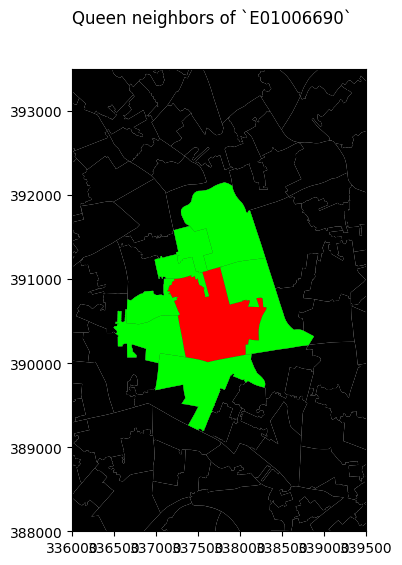

In [20]:
# Setup figure
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot base layer of polygons
df.plot(ax=ax, facecolor='k', linewidth=0.1)
# Select focal polygon
focus = df[df['LSOA11CD'] == 'E01006690']
# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)
# Plot neighbors
neis = df[df['LSOA11CD'].isin(w_queen['E01006690'].keys())]
neis.plot(ax=ax, facecolor='lime', linewidth=0)
# Title
f.suptitle("Queen neighbors of `E01006690`")
# Style and display on screen
ax.set_ylim(388000, 393500)
ax.set_xlim(336000, 339500)
plt.show()

Note how the figure is built gradually, from the base map, to the focal point, to its neighborhood. Once the entire figure is plotted, we zoom into the area of interest.

-   **Rook**

Rook contiguity is similar to and, in many ways, superseded by queen contiguity. However, since it sometimes comes up in the literature, it is useful to know about it. The main idea is the same: two observations are neighbors if they share some of their boundary lines. However, in the rook case, it is not enough with sharing only one point, it needs to be at least a segment of their boundary. In most applied cases, these differences usually boil down to how the geocoding was done, but in some cases, such as when we use raster data or grids, this approach can differ more substantively and it thus makes more sense.

From a technical point of view, constructing a rook matrix is very similar:

In [21]:
w_rook = weights.Rook.from_dataframe(df, ids="LSOA11CD")
w_rook

The output is of the same type as before, a W object that can be queried and used in very much the same way as any other one.

### Distance

Distance-based matrices assign the weight to each pair of observations as a function of how far from each other they are. How this is translated into an actual weight varies across types and variants, but they all share that the ultimate reason why two observations are assigned some weight is due to the distance between them.

-   $K$**-nearest neighbours**

One approach to define weights is to take the distances between a given observation and the rest of the set, rank them, and consider as neighbors the $k$ closest ones. That is exactly what the $k$-nearest neighbors (KNN) criterion does.

To calculate KNN weights, we can use a similar function as before and derive them from a shapefile:

In [22]:
knn5 = weights.KNN.from_dataframe(df, k=5)
knn5

Note how we need to specify the number of nearest neighbors we want to consider with the argument k. Since it is a polygon shapefile that we are passing, the function will automatically compute the centroids to derive distances between observations. Alternatively, we can provide the points in the form of an array, skipping this way the dependency of a file on disk:

In [23]:
# Extract centroids
cents = df.centroid
# Extract coordinates into an array
pts = pd.DataFrame(
    {"X": cents.x, "Y": cents.y}
).values
# Compute KNN weights
knn5_from_pts = weights.KNN.from_array(pts, k=5)
knn5_from_pts

Like before, we can make a map to visualise the neighbourhood of observation E01006690:

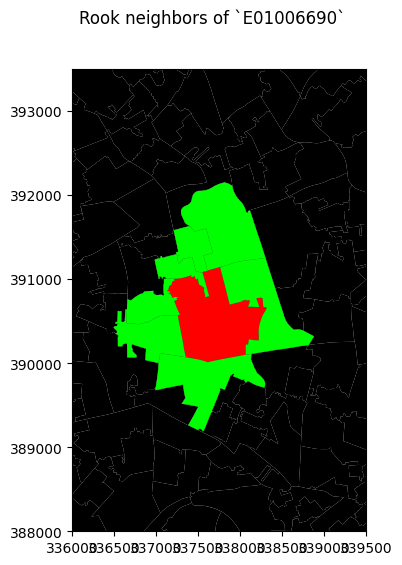

In [24]:
# Setup figure
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot base layer of polygons
df.plot(ax=ax, facecolor='k', linewidth=0.1)
# Select focal polygon
focus = df[df['LSOA11CD'] == 'E01006690']
# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)
# Plot neighbors
neis = df[df['LSOA11CD'].isin(w_rook['E01006690'].keys())]
neis.plot(ax=ax, facecolor='lime', linewidth=0)
# Title
f.suptitle("Rook neighbors of `E01006690`")
# Style and display on screen
ax.set_ylim(388000, 393500)
ax.set_xlim(336000, 339500)
plt.show()

For the selected central polygon, both the rook and queen neighbourhoods look the same!

-   **Distance band**

Another approach to build distance-based spatial weights matrices is to "draw a circle" of certain radius (in case your observation is a polygon, as is our case, the circle should be centered at the centroid of each polygon) and consider as neighbours every observation (whose centroid) falls within the circle. The technique has two main variations: binary and continuous. In the former one, every neighbor is given a weight of one, while in the second one, the weights can be further tweaked by the distance to the observation of interest. We start looking at the binary variation.

First, we create a list of neighbours at a distance less than 2000 meters away from each polygon:

In [25]:
w_dist2kmB = weights.DistanceBand.from_dataframe(df, 2000)

This creates a binary matrix that considers neighbors of an observation every polygon whose centroid is closer than 2,000 metres (2Km) of the centroid of such observation. To check, for example, the neighborhood of polygon E01006690, we need to know access it by its index in `df`:

In [26]:
w_dist2kmB[df[df['LSOA11CD'] == 'E01006690'].index[0]]

{0: 1.0,
 26: 1.0,
 35: 1.0,
 38: 1.0,
 40: 1.0,
 41: 1.0,
 42: 1.0,
 56: 1.0,
 68: 1.0,
 69: 1.0,
 70: 1.0,
 71: 1.0,
 124: 1.0,
 149: 1.0,
 154: 1.0,
 166: 1.0,
 167: 1.0,
 168: 1.0,
 169: 1.0,
 170: 1.0,
 171: 1.0,
 172: 1.0,
 185: 1.0,
 188: 1.0,
 190: 1.0,
 192: 1.0,
 193: 1.0,
 194: 1.0,
 195: 1.0,
 196: 1.0,
 197: 1.0,
 198: 1.0,
 199: 1.0,
 200: 1.0,
 217: 1.0,
 218: 1.0,
 219: 1.0,
 220: 1.0,
 221: 1.0,
 228: 1.0,
 229: 1.0,
 230: 1.0,
 233: 1.0,
 272: 1.0,
 273: 1.0,
 286: 1.0,
 292: 1.0}

Note that the units in which you specify the distance directly depend on the CRS in which the spatial data are projected, and this has nothing to do with the weights building but it can affect it significantly. Recall how you can check the CRS of a GeoDataFrame:

In [27]:
df.crs

<Projected CRS: PROJCS["Transverse_Mercator",GEOGCS["GCS_OSGB 1936 ...>
Name: Transverse_Mercator
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: OSGB_1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In this case, you can see the unit is expressed in metres (and not degrees), hence we set the threshold to 2,000 for a circle of 2km of radius.

Once again, we create a map to visualise this neighbourhood:

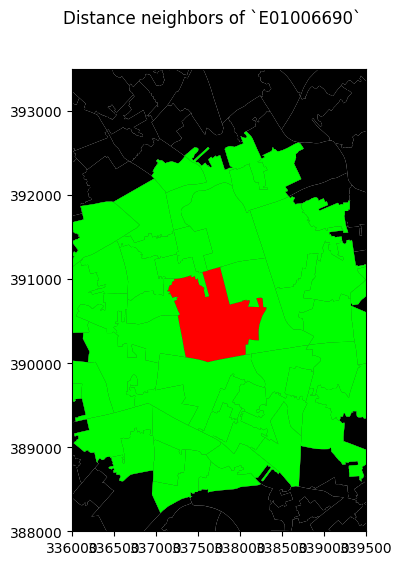

In [28]:
# Setup figure
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot base layer of polygons
df.plot(ax=ax, facecolor='k', linewidth=0.1)
# Select focal polygon
focus = df[df['LSOA11CD'] == 'E01006690']
# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)
# Plot neighbors
neis = df.loc[w_dist2kmB[df[df['LSOA11CD'] == 'E01006690'].index[0]].keys()]
neis.plot(ax=ax, facecolor='lime', linewidth=0)
# Title
f.suptitle("Distance neighbors of `E01006690`")
# Style and display on screen
ax.set_ylim(388000, 393500)
ax.set_xlim(336000, 339500)
plt.show()

-   **Inverse distance weights**

An extension of the weights above is to introduce further detail by assigning different weights to different neighbours within the radius based on how far they are from the observation of interest. For example, we could think of assigning the inverse of the distance between the centroid of a polygon $i$ and the centroid of a neighouburing polygon $j$ as $w_{ij} = \dfrac{1}{d_{ij}}$, where $d_{ij}$ is the distance in meters between the centroids. This way, polygons that are closer to $i$ "weight" more.

This can be computed by running the following command:

In [29]:
w_dist2kmC = weights.DistanceBand.from_dataframe(df, 2000, binary=False)

/Users/carmen/anaconda3/envs/envs363-563/lib/python3.11/site-packages/scipy/sparse/_data.py:134: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


Let's inspect the weights given to the neighbours of E01006690 in `df`:

In [30]:
w_dist2kmC[df[df['LSOA11CD'] == 'E01006690'].index[0]]

{0: 0.0005792682298423491,
 26: 0.0005652380463316371,
 35: 0.0005081427736683873,
 38: 0.0005519032395429389,
 40: 0.0005210462443199065,
 41: 0.0006977875200598445,
 42: 0.0005829152923947856,
 56: 0.0005128690004944388,
 68: 0.0005295145979051724,
 69: 0.0005138330262660343,
 70: 0.0006473018461660037,
 71: 0.000503348501410663,
 124: 0.0005771986613124313,
 149: 0.0005332922191931754,
 154: 0.0005579852194045766,
 166: 0.001320115452290246,
 167: 0.0016898106255168294,
 168: 0.000666068859627656,
 169: 0.0008817312588051628,
 170: 0.001120923796462639,
 171: 0.0009790712779402275,
 172: 0.001403469553911711,
 185: 0.0007681438141510114,
 188: 0.0007269958252949354,
 190: 0.0005499230621665081,
 192: 0.0013390451319917913,
 193: 0.0007313842296388731,
 194: 0.0007990860888084788,
 195: 0.0006961625640513184,
 196: 0.000573301567399397,
 197: 0.001009044334260805,
 198: 0.0010528395831202145,
 199: 0.0007892682323588023,
 200: 0.0009519836566654489,
 217: 0.0007227059907193832,
 218:

Note that none of them should be smaller than 1/2,000 = 0.0005 since all the neighbours are within a 2,000 meter radius from the centroid of the first polygon.

Following this logic of more detailed weights through distance, there is a temptation to take it further and consider everyone else in the dataset as a neighbor whose weight will then get modulated by the distance effect shown above. However, although conceptually correct, this approach is not always the most computationally or practical one. Because of the nature of spatial weights matrices, particularly because of the fact their size is $N$ by $N$ if all the neighbours are present, they can grow substantially large. A way to cope with this problem is by making sure they remain fairly sparse (with many zeros). Sparsity is typically ensured in the case of contiguity or KNN by construction but, with inverse distance, it needs to be imposed as, otherwise, the matrix could be potentially entirely dense (no zero values other than the diagonal). In practical terms, what is usually done is to impose a distance threshold beyond which no weight is assigned and interaction is assumed to be non-existent, as we did here by setting this threshold to 2,000 meters. Beyond being computationally feasible and scalable, results from this approach usually do not differ much from a fully "dense" one as the additional information that is included from further observations is almost ignored due to the small weight they receive.

### Block weights

Block weights connect every observation in a dataset that belongs to the same category in a list provided ex-ante. Usually, this list will have some relation to geography an the location of the observations but, technically speaking, all one needs to create block weights is a list of memberships. In this class of weights, neighboring observations, those in the same group, are assigned a weight of one, and the rest receive a weight of zero.

In this example, we will build a spatial weights matrix that connects every LSOA with all the other ones in the same MSOA. See how the MSOA code is expressed for every LSOA:

In [31]:
df.head()

LSOA11CD   MSOA11CD                                           geometry
0  E01006512  E02001377  POLYGON ((336103.358 389628.580, 336103.416 38...
1  E01006513  E02006932  POLYGON ((335173.781 389691.538, 335169.798 38...
2  E01006514  E02001383  POLYGON ((335495.676 389697.267, 335495.444 38...
3  E01006515  E02001383  POLYGON ((334953.001 389029.000, 334951.000 38...
4  E01006518  E02001390  POLYGON ((335354.015 388601.947, 335354.000 38...

To build a block spatial weights matrix that connects as neighbors all the LSOAs in the same MSOA, we only require the mapping of codes. Using `PySAL`, this is a one-line task:

In [32]:
w_block = weights.block_weights(df['MSOA11CD'])

/Users/carmen/anaconda3/envs/envs363-563/lib/python3.11/site-packages/libpysal/weights/util.py:296: UserWarning: The weights matrix is not fully connected: 
 There are 61 disconnected components.
  w = W(neighbors, **kwargs)


Observations are named after the order the occupy in the list. For example, for the first observation:

In [33]:
w_block[0]

{218: 1.0, 219: 1.0, 220: 1.0, 292: 1.0}

If we want to search the neighbours of a specific LSOA, for example, E01006690, then we need to run:

In [34]:
w_block[df[df['LSOA11CD'] == 'E01006690'].index[0]]

{167: 1.0, 170: 1.0, 228: 1.0, 229: 1.0}

Another option is to remap the IDs of the observations so that they are indexed according to the name of the LSOAs:

In [35]:
w_block.remap_ids(df.LSOA11CD)

Now if you can access E01006690 more easily:

In [36]:
w_block['E01006690']

{'E01006692': 1.0, 'E01006695': 1.0, 'E01006759': 1.0, 'E01006760': 1.0}

## Standardising spatial weights matrices

In the context of many spatial analysis techniques, a spatial weights matrix with raw values (e.g. ones and zeros for the binary case) is not always the best suiting one for analysis and some sort of transformation is required. This implies modifying each weight so they conform to certain rules. A common one is being row-normalised. This simply means, that for each observation, the weights corresponding to the neighbours must add to 1. We will look into how we can do this in the case of the queen neighbourhood.

Consider the original queen weights, for observation E01006690:

In [37]:
w_queen['E01006690']

{'E01006697': 1.0,
 'E01006695': 1.0,
 'E01006691': 1.0,
 'E01006759': 1.0,
 'E01006692': 1.0,
 'E01033763': 1.0,
 'E01006720': 1.0}

Since it is contiguity, every neighbor gets one, the rest zero weight. We can check if the object w_queen has been transformed or not by calling the argument transform:

In [38]:
w_queen.transform

'O'

where `O` stands for “original”, so no transformations have been applied yet. If we want to apply a row-based transformation, so every row of the matrix sums up to one, we modify the `transform` attribute as follows:

In [39]:
w_queen.transform = 'R'

Now we can check the weights of the same observation as above and find they have been modified:

In [40]:
w_queen['E01006690']

{'E01006697': 0.14285714285714285,
 'E01006695': 0.14285714285714285,
 'E01006691': 0.14285714285714285,
 'E01006759': 0.14285714285714285,
 'E01006692': 0.14285714285714285,
 'E01033763': 0.14285714285714285,
 'E01006720': 0.14285714285714285}

Save for precission issues, the sum of weights for all the neighbors is one:

In [41]:
pd.Series(w_queen['E01006690']).sum()

0.9999999999999998

PySAL supports the following transformations:

-   `O`: original, returning the object to the initial state.

-   `B`: binary, with every neighbor having assigned a weight of one.

-   `R`: row, with all the neighbors of a given observation adding up to one.

-   `V`: variance stabilizing, with the sum of all the weights being constrained to the number of observations.

## Spatial lag

One of the most direct applications of spatial weight matrices is the so-called *spatial lag*. The spatial lag of a given variable observed at several locations is the product of a spatial weight matrix and the variable itself:

$$
Y_{sl} = WY
$$ where $Y$ is a $Nx1$ vector with the $N$ observations of the variable. Recall that the product of a matrix and a vector equals the sum of a row by column element multiplication for the resulting value of a given row. In terms of the spatial lag:

$$
y_{sl-i}= \sum_{j=1}^Nw_{ij}y_j
$$ If we use row-standardized weights, $w_{ij}$ becomes a proportion between zero and one, and $y_{sl-i}$ can be seen as a weighted average of the variable $Y$ in the neighborhood of $i$.

To illustrate this here, we will use the area of each polygon as the variable $Y$ of interest. And to make things a bit nicer later on, we will keep the log of the area instead of the raw measurement. Hence, let’s create a column for it:

In [42]:
# Calculate the logarithm of the area of each polygon and add it as a new column named 'area'
df["area"] = np.log(df.area)

The spatial lag is a key element of many spatial analysis techniques, as we will see later on and, as such, it is fully supported in PySAL. To compute the spatial lag of a given variable, area for example:

In [43]:
# Row-standardize the queen matrix
w_queen.transform = 'R'
# Compute spatial lag of `area`
w_queen_score = weights.lag_spatial(w_queen, df["area"])
# Print the first five elements
w_queen_score[:5]

array([12.40660189, 12.54225296, 12.28284814, 12.61675295, 12.55042815])

The second line of uncommented code above contains the actual computation, which is highly optimised in PySAL. Note that, despite passing in a `pd.Series` object, the output is a numpy array. This however, can be added directly to the table `df`:

In [44]:
df['w_area'] = w_queen_score

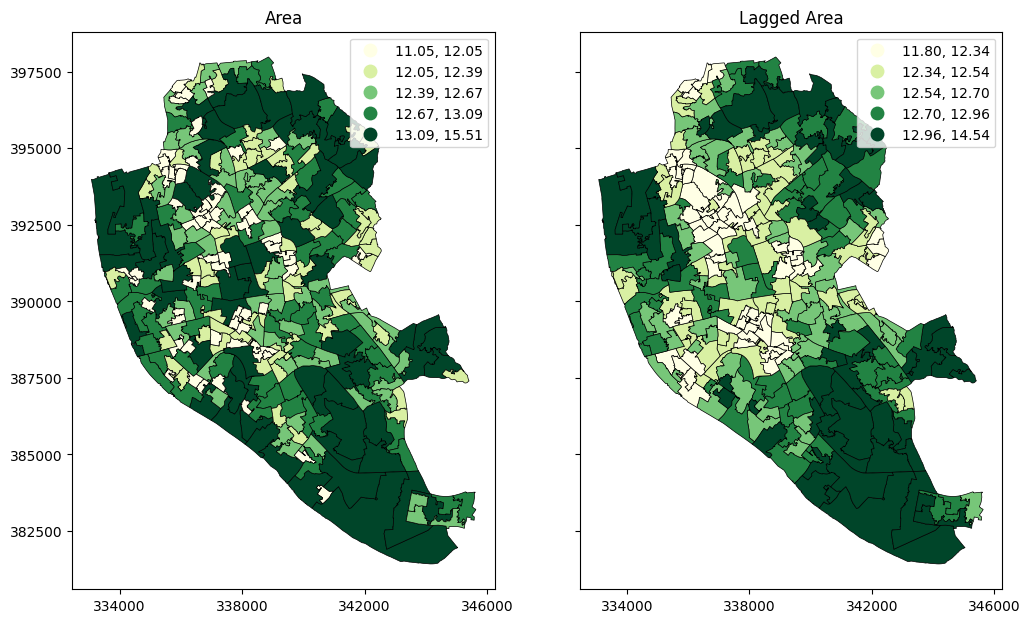

In [45]:
# Set up the figure with two subplots (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

# Plot the 'area' variable
df.plot(column='area', cmap='YlGn', scheme='quantiles', k=5, legend=True, ax=ax1, edgecolor='black', linewidth=0.5)
ax1.set_title('Area')

ax1.set_xticks([334000, 338000, 342000, 346000], [334000, 338000, 342000, 346000])

# Plot the spatially lagged 'w_area' variable
df.plot(column='w_area', cmap='YlGn', scheme='quantiles', k=5, legend=True, ax=ax2, edgecolor='black', linewidth=0.5)
ax2.set_title('Lagged Area')

ax2.set_xticks([334000, 338000, 342000, 346000], [334000, 338000, 342000, 346000])

plt.show()

## Moran plot

The Moran Plot is a graphical way to start exploring the concept of spatial autocorrelation, and it is a good application of spatial weight matrices and the spatial lag. In essence, it is a standard scatter plot in which a given variable (`area`, for example) is plotted against its own spatial lag. Usually, a fitted line is added to include more information.

We create a Moran plot as follows:

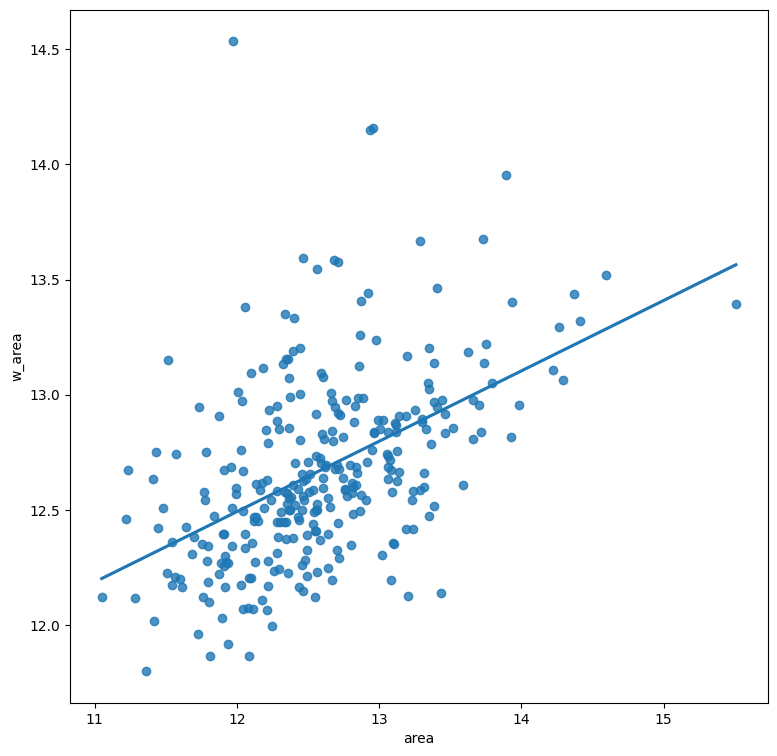

In [46]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x="area", y="w_area", data=df, ci=None)
# Display
plt.show()

In order to easily compare different scatter plots and spot outlier observations, it is common practice to standardize the values of the variable before computing its spatial lag and plotting it. This can be accomplished by substracting the average value and dividing the result by the standard deviation:

$$
z_i = \dfrac{y_i - \bar{y}}{\sigma_y}
$$ where $z_i$ is the standardised version of $y_i$, also knwon as $z$-score, $\bar{y}$ is the average of the variable, and $\sigma_y$ its standard deviation.

We compute the $z$-score by running the code below. We store it as a new column in `df` called `area_z`:

In [47]:
# Standardize the 'area' variable and add it as a new column named 'area_z'
df["area_z"] = (df["area"] - np.mean(df["area"])) / np.std(df["area"])

Creating a standardized Moran Plot implies that average values are centered in the plot (as they are zero when standardized) and dispersion is expressed in standard deviations, with the rule of thumb of values greater or smaller than two standard deviations being outliers. A standardized Moran Plot also partitions the space into four quadrants that represent different situations:

-   High-High (HH): values above average surrounded by values above average.
-   Low-Low (LL): values below average surrounded by values below average.
-   High-Low (HL): values above average surrounded by values below average.
-   Low-High (LH): values below average surrounded by values above average.

These will be further explored once spatial autocorrelation has been properly introduced in subsequent blocks.

Below we create a Moran plot with the $z$-scores, but first we need to computer the lag of the $z$-scores:

In [48]:
w_queen_score_z = weights.lag_spatial(w_queen, df["area_z"])
df["w_area_z"] = w_queen_score_z

And the plot follows as before, but replacing the to the new standardised variables:

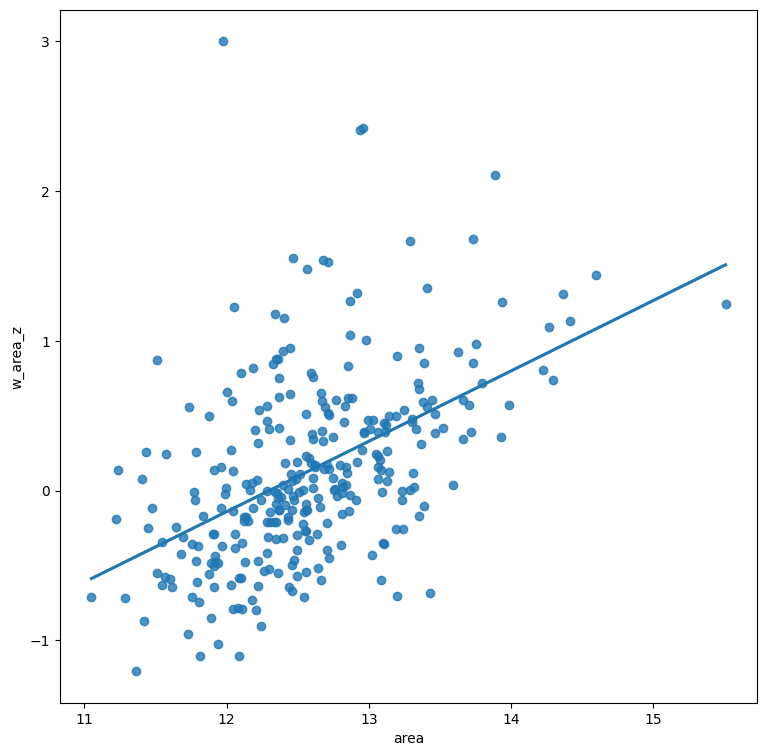

In [49]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x="area", y="w_area_z", data=df, ci=None)
# Display
plt.show()